# 📌 Détection d'Anomalies dans la Qualité de l'Huile d'Olive avec Autoencodeur


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import regularizers
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.models import load_model
import numpy as np
import ast
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")


2025-09-03 21:28:27.594136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756934907.900149      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756934907.976465      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## EDA

### Chargement du Jeu de Données

In [2]:
df = pd.read_csv('/kaggle/input/olive-oil/Fluorescence_olive_oil_dataset.csv')


In [3]:
df.head()

,Unnamed: 0,Sample,Repetition,Led,Data,Quality,FAEES,K232,K270,Acidity,Peroxide Index
0,0,D73,19,2,"[1490.0,1521.0,1544.0,1509.0,1491.0,1574.0,157...",EXTRA,15.0,1.66,0.14,0.20,8.9
1,1,D35,19,2,"[1487.0,1518.0,1537.0,1506.0,1485.0,1562.0,156...",EXTRA,8.0,1.63,0.12,0.17,6.4
2,2,D77,3,1,"[1490.0,1528.0,1541.0,1509.0,1486.0,1577.0,157...",VIRGEN,26.0,1.74,0.13,0.24,10.4
3,3,D09,8,2,"[1486.0,1517.0,1531.0,1501.0,1483.0,1558.0,155...",LAMPANTE,NaN,NaN,NaN,NaN,NaN
4,4,D35,14,1,"[1492.0,1515.0,1534.0,1505.0,1487.0,1568.0,156...",EXTRA,8.0,1.63,0.12,0.17,6.4


### Aperçu statistique

In [4]:
df.describe()

,Unnamed: 0,Repetition,Led,FAEES,K232,K270,Acidity,Peroxide Index
count,960.000000,960.000000,960.000000,720.000000,720.000000,720.000000,880.000000,840.000000
mean,541.183333,9.500000,1.500000,18.666667,1.591944,0.132333,0.461364,8.009524
std,312.607160,5.769287,0.500261,11.183139,0.116583,0.015969,0.513697,3.699938
min,0.000000,0.000000,1.000000,7.000000,1.403000,0.108000,0.160000,4.600000
25%,269.750000,4.750000,1.000000,9.000000,1.537000,0.120000,0.180000,5.000000
50%,545.500000,9.500000,1.500000,15.500000,1.630000,0.130000,0.255000,8.400000
75%,812.250000,14.250000,2.000000,26.000000,1.630000,0.140000,0.400000,8.900000
max,1081.000000,19.000000,2.000000,47.000000,1.910000,0.170000,2.160000,22.000000


### Suppression de colonnes inutiles dans le DataFrame


In [5]:
df = df.drop(['Unnamed: 0', 'Sample'], axis=1)

### transformation de les valeurs de la colonne "Led" selon une nouvelle codification binaire pour préparer les données 

In [6]:
df["Led"]=df["Led"].replace({1:0,2:1})

### Conversion des chaînes en listes Python

In [7]:
data_to_array=df["Data"].apply(lambda x: ast.literal_eval(x))

### Expansion des listes en colonnes , suppression de la colonne originale "Data" et concaténation

In [8]:
data_expanded = pd.DataFrame(data_to_array.to_list())
data_expanded_cols=data_expanded.columns
df = df.drop(columns=['Data']).reset_index(drop=True)
df = pd.concat([df, data_expanded], axis=1)

In [9]:
df.head(5)

,Repetition,Led,Quality,FAEES,K232,K270,Acidity,Peroxide Index,0,1,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,19,1,EXTRA,15.0,1.66,0.14,0.20,8.9,1490.0,1521.0,...,1641.0,1590.0,1595.0,1633.0,1545.0,1594.0,1614.0,1490.0,1605.0,1583.0
1,19,1,EXTRA,8.0,1.63,0.12,0.17,6.4,1487.0,1518.0,...,1626.0,1586.0,1588.0,1619.0,1547.0,1586.0,1610.0,1488.0,1598.0,1574.0
2,3,0,VIRGEN,26.0,1.74,0.13,0.24,10.4,1490.0,1528.0,...,1643.0,1592.0,1596.0,1631.0,1550.0,1596.0,1616.0,1486.0,1598.0,1579.0
3,8,1,LAMPANTE,NaN,NaN,NaN,NaN,NaN,1486.0,1517.0,...,1611.0,1574.0,1577.0,1602.0,1534.0,1572.0,1593.0,1483.0,1579.0,1565.0
4,14,0,EXTRA,8.0,1.63,0.12,0.17,6.4,1492.0,1515.0,...,1611.0,1569.0,1573.0,1605.0,1535.0,1573.0,1592.0,1476.0,1583.0,1560.0


### Séparation des colonnes catégorielles et numériques

In [10]:
categorical_columns=["Repetition","Quality","Led"]
numerical_columns = ["FAEES", "K232", "K270", "Acidity", "Peroxide Index"]
numerical_columns.extend(data_expanded_cols)

### Vérification des valeurs manquantes

In [11]:
df.isna().sum()

Repetition      0
Led             0
Quality         0
FAEES         240
K232          240
             ... 
1019            0
1020            0
1021            0
1022            0
1023            0
Length: 1032, dtype: int64

### Vérification de l'asymétrie des colonnes numériques

In [12]:
df[numerical_columns].skew().head(6)

FAEES             1.091297
K232              0.713190
K270              0.713331
Acidity           2.371726
Peroxide Index    2.414490
0                 0.341968
dtype: float64

### Remplissage des valeurs manquantes par la médiane ( skewness > 0.5)

In [13]:
cols_to_median=['FAEES', 'K232', 'K270', 'Acidity', 'Peroxide Index']
df[cols_to_median]=df[cols_to_median].fillna(df[cols_to_median].median())

### Vérification finale des valeurs manquantes

In [14]:
df.isna().sum()

Repetition    0
Led           0
Quality       0
FAEES         0
K232          0
             ..
1019          0
1020          0
1021          0
1022          0
1023          0
Length: 1032, dtype: int64

In [15]:
encoder = OneHotEncoder(sparse_output=False)
encoded_array = encoder.fit_transform(df[['Quality']])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['Quality']))
df2 = df.drop(columns=['Quality']).reset_index(drop=True)
df2 = pd.concat([df2, encoded_df], axis=1)

In [16]:
df2.head()

,Repetition,Led,FAEES,K232,K270,Acidity,Peroxide Index,0,1,2,...,1017,1018,1019,1020,1021,1022,1023,Quality_EXTRA,Quality_LAMPANTE,Quality_VIRGEN
0,19,1,15.0,1.66,0.14,0.200,8.9,1490.0,1521.0,1544.0,...,1633.0,1545.0,1594.0,1614.0,1490.0,1605.0,1583.0,1.0,0.0,0.0
1,19,1,8.0,1.63,0.12,0.170,6.4,1487.0,1518.0,1537.0,...,1619.0,1547.0,1586.0,1610.0,1488.0,1598.0,1574.0,1.0,0.0,0.0
2,3,0,26.0,1.74,0.13,0.240,10.4,1490.0,1528.0,1541.0,...,1631.0,1550.0,1596.0,1616.0,1486.0,1598.0,1579.0,0.0,0.0,1.0
3,8,1,15.5,1.63,0.13,0.255,8.4,1486.0,1517.0,1531.0,...,1602.0,1534.0,1572.0,1593.0,1483.0,1579.0,1565.0,0.0,1.0,0.0
4,14,0,8.0,1.63,0.12,0.170,6.4,1492.0,1515.0,1534.0,...,1605.0,1535.0,1573.0,1592.0,1476.0,1583.0,1560.0,1.0,0.0,0.0


## Classification Multi-Classe

### Split des données en train, validation et test

In [17]:
train_data, test_data = train_test_split(df2, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

In [18]:
num_cols = df2.columns[(df2.nunique() != 2)] 
num_cols

Index([    'Repetition',          'FAEES',           'K232',           'K270',
              'Acidity', 'Peroxide Index',                0,                1,
                      2,                3,
       ...
                   1014,             1015,             1016,             1017,
                   1018,             1019,             1020,             1021,
                   1022,             1023],
      dtype='object', length=1030)

### Normalisation des données

In [19]:
def scale_data(data,cols):
    data_to_scale=data[cols]
    min_val = tf.reduce_min(data[cols]).numpy()
    max_val= tf.reduce_max(data[cols]).numpy()
    data[cols] = (data[cols] - min_val) / (max_val - min_val)
    data = tf.cast(data, tf.float32)
    return data

In [20]:
train_data=scale_data(train_data,num_cols)
test_data=scale_data(test_data,num_cols)
val_data=scale_data(val_data,num_cols)
train_data = tf.cast(train_data, tf.float32)
test_data=tf.cast(test_data, tf.float32)
val_data=tf.cast(val_data, tf.float32)

2025-09-03 21:28:49.949884: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Séparation des features et labels

In [21]:
X_train = train_data[:, :-3]  
y_train = train_data[:, -3:]  

X_test = test_data[:, :-3]  
y_test = test_data[:, -3:] 

X_val= val_data[:, :-3]
y_val= val_data[:,-3:]

In [22]:
class QualityClassifier(tf.keras.Model):
  def __init__(self):
    super(QualityClassifier, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Dense(1024, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(64,activation="relu"),
        ])

    self.classifier = tf.keras.Sequential([
        layers.Dense(32, activation="relu"),  
        layers.Dense(3, activation="softmax"),  
        ])
        
  def call(self, x):
    encoded = self.encoder(x)
    class_probs = self.classifier(encoded)
    return class_probs

autoencoder = QualityClassifier()
autoencoder.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

### Entraînement de l'autoencodeur

In [23]:
history = autoencoder.fit(
          X_train,
          y_train, 
          epochs=90, 
          batch_size=64,
          validation_data=(X_val, y_val),
          shuffle=True,
        )

Epoch 1/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.4072 - loss: 1.0349 - val_accuracy: 0.5065 - val_loss: 0.9447
Epoch 2/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5287 - loss: 0.9016 - val_accuracy: 0.4610 - val_loss: 0.8910
Epoch 3/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5652 - loss: 0.7864 - val_accuracy: 0.5649 - val_loss: 0.6960
Epoch 4/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5304 - loss: 0.6967 - val_accuracy: 0.5909 - val_loss: 0.6387
Epoch 5/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5799 - loss: 0.6698 - val_accuracy: 0.6299 - val_loss: 0.6096
Epoch 6/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6253 - loss: 0.6194 - val_accuracy: 0.6623 - val_loss: 0.6053
Epoch 7/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5898 - loss: 0.6195 - val_accuracy: 0.6429 - val_loss: 0.6270
Epoch 8/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6398 - loss: 0.5971 - val_accuracy: 0.6429 - v

### Prédictions

In [24]:
predictions=autoencoder.predict(X_test)
y_pred = to_categorical(np.argmax(predictions, axis=1), num_classes=3)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


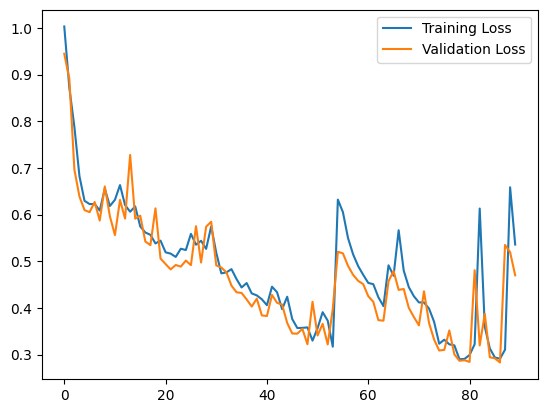

In [25]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [26]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="macro")  
print("Accuracy:",accuracy_score(y_test,y_pred))
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7135416666666666
Precision: 0.829301269979236
Recall: 0.7243265993265994
F1-score: 0.6849969412743713


## Classification biniare

In [27]:
train_np = train_data.numpy()
test_np = test_data.numpy()
val_np = val_data.numpy()

X_train = train_np[:, :-3]
X_test = test_np[:, :-3]  
X_val = val_np[:, :-3]


y_train_binary = train_np[:, -3].astype(int) 
y_test_binary = test_np[:, -3].astype(int)
y_val_binary = val_np[:, -3].astype(int)

print("Binary label distribution:")
print("Train EXTRA:", np.sum(y_train_binary), "NOT EXTRA:", len(y_train_binary) - np.sum(y_train_binary))
print("Test EXTRA:", np.sum(y_test_binary), "NOT EXTRA:", len(y_test_binary) - np.sum(y_test_binary))
print("Val EXTRA:", np.sum(y_val_binary), "NOT EXTRA:", len(y_val_binary) - np.sum(y_val_binary))

print("Feature shape:", X_train.shape)

Binary label distribution:
Train EXTRA: 266 NOT EXTRA: 348
Test EXTRA: 72 NOT EXTRA: 120
Val EXTRA: 62 NOT EXTRA: 92
Feature shape: (614, 1031)


In [28]:
class SimpleAutoencoder(tf.keras.Model):
    def __init__(self, input_dim):
        super(SimpleAutoencoder, self).__init__()
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Dense(512, activation="relu"),
            layers.Dense(128, activation="relu"), 
            layers.Dense(64, activation="relu")  # bottleneck
        ])
        # Decoder  
        self.decoder = tf.keras.Sequential([
            layers.Dense(128, activation="relu"),
            layers.Dense(512, activation="relu"),
            layers.Dense(input_dim, activation="linear")  # reconstruct input
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

input_dim = X_train.shape[1]  # 1031 features
autoencoder = SimpleAutoencoder(input_dim)
autoencoder.compile(optimizer="adam", loss="mse")

print("Autoencoder created with input dimension:", input_dim)

Autoencoder created with input dimension: 1031


In [29]:
X_train_normal = X_train[y_train_binary == 1]
X_val_normal = X_val[y_val_binary == 1]

print("Training samples:")
print("Normal samples for training:", X_train_normal.shape[0])
print("Normal samples for validation:", X_val_normal.shape[0])

history = autoencoder.fit(
    X_train_normal, X_train_normal,  
    epochs=100,
    batch_size=32,
    validation_data=(X_val_normal, X_val_normal),
    verbose=1
)

print("Training completed!")

Training samples:
Normal samples for training: 266
Normal samples for validation: 62
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0369 - val_loss: 0.0065
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0050 - val_loss: 0.0019
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0016 - val_loss: 9.9004e-04
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9.0047e-04 - val_loss: 7.5585e-04
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 6.8616e-04 - val_loss: 6.6310e-04
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.8926e-04 - val_loss: 6.1644e-04
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.6461e-04 - val_loss: 6.0609e-04
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.5731e-04 - val_loss: 5.7501e-04
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.4311e-04 - val_loss: 5.3327e-04
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.0890e-04 - val_loss: 5.0771e-04
Epoch 11/100
9

In [30]:
train_reconstructions = autoencoder(X_train_normal)
train_mse = tf.keras.losses.mse(X_train_normal, train_reconstructions)

# Set threshold as 95th percentile of training errors
threshold = np.percentile(train_mse, 95)
print(f"Anomaly threshold: {threshold:.4f}")

test_reconstructions = autoencoder(X_test)
test_mse = tf.keras.losses.mse(X_test, test_reconstructions)

y_pred_anomaly = (test_mse > threshold).numpy().astype(int)

y_true_anomaly = 1 - y_test_binary  # flip: 0=normal, 1=anomaly

print("Prediction distribution:")
print("Predicted normal:", np.sum(y_pred_anomaly == 0))
print("Predicted anomaly:", np.sum(y_pred_anomaly == 1))
print("True normal:", np.sum(y_true_anomaly == 0)) 
print("True anomaly:", np.sum(y_true_anomaly == 1))

Anomaly threshold: 0.0000
Prediction distribution:
Predicted normal: 81
Predicted anomaly: 111
True normal: 72
True anomaly: 120


In [31]:
accuracy = accuracy_score(y_true_anomaly, y_pred_anomaly)
precision = precision_score(y_true_anomaly, y_pred_anomaly)
recall = recall_score(y_true_anomaly, y_pred_anomaly)
f1 = f1_score(y_true_anomaly, y_pred_anomaly)

print("=== ANOMALY DETECTION RESULTS ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# confusion matrix
cm = confusion_matrix(y_true_anomaly, y_pred_anomaly)
print("\nConfusion Matrix:")
print("Predicted:  Normal  Anomaly")
print(f"True Normal:   {cm[0,0]:2d}     {cm[0,1]:2d}")
print(f"True Anomaly:  {cm[1,0]:2d}     {cm[1,1]:2d}")



=== ANOMALY DETECTION RESULTS ===
Accuracy: 0.9219
Precision: 0.9730
Recall: 0.9000
F1-score: 0.9351

Confusion Matrix:
Predicted:  Normal  Anomaly
True Normal:   69      3
True Anomaly:  12     108


In [32]:
thresholds_to_try = [90, 92, 94, 95, 96, 97, 98]
best_f1 = 0
best_threshold = threshold

print("Threshold optimization:")
print("Percentile | Threshold | Accuracy | Precision | Recall | F1-score")
print("-" * 65)

for percentile in thresholds_to_try:
    thresh = np.percentile(train_mse, percentile)
    pred_anomaly = (test_mse > thresh).numpy().astype(int)
    
    acc = accuracy_score(y_true_anomaly, pred_anomaly)
    prec = precision_score(y_true_anomaly, pred_anomaly)
    rec = recall_score(y_true_anomaly, pred_anomaly)
    f1_temp = f1_score(y_true_anomaly, pred_anomaly)
    
    print(f"{percentile:8d} | {thresh:8.5f} | {acc:8.4f} | {prec:9.4f} | {rec:6.4f} | {f1_temp:8.4f}")
    
    if f1_temp > best_f1:
        best_f1 = f1_temp
        best_threshold = thresh
        best_percentile = percentile

print(f"\nBest threshold: {best_threshold:.5f} (at {best_percentile}th percentile)")
print(f"Best F1-score: {best_f1:.4f}")

Threshold optimization:
Percentile | Threshold | Accuracy | Precision | Recall | F1-score
-----------------------------------------------------------------
      90 |  0.00001 |   0.9271 |    0.9569 | 0.9250 |   0.9407
      92 |  0.00001 |   0.9271 |    0.9732 | 0.9083 |   0.9397
      94 |  0.00001 |   0.9219 |    0.9730 | 0.9000 |   0.9351
      95 |  0.00001 |   0.9219 |    0.9730 | 0.9000 |   0.9351
      96 |  0.00001 |   0.9115 |    0.9725 | 0.8833 |   0.9258
      97 |  0.00001 |   0.9062 |    0.9811 | 0.8667 |   0.9204
      98 |  0.00001 |   0.8906 |    0.9806 | 0.8417 |   0.9058

Best threshold: 0.00001 (at 90th percentile)
Best F1-score: 0.9407


In [33]:
optimal_threshold = np.percentile(train_mse, 90)
y_pred_final = (test_mse > optimal_threshold).numpy().astype(int)

final_accuracy = accuracy_score(y_true_anomaly, y_pred_final)
final_precision = precision_score(y_true_anomaly, y_pred_final)
final_recall = recall_score(y_true_anomaly, y_pred_final)
final_f1 = f1_score(y_true_anomaly, y_pred_final)

print("=== FINAL OPTIMIZED RESULTS ===")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1-score: {final_f1:.4f}")

cm_final = confusion_matrix(y_true_anomaly, y_pred_final)
print("\nFinal Confusion Matrix:")
print("Predicted:    Normal  Anomaly")
print(f"True Normal:     {cm_final[0,0]:2d}     {cm_final[0,1]:2d}")
print(f"True Anomaly:    {cm_final[1,0]:2d}     {cm_final[1,1]:2d}")

print(f" autoencoder results:")
print(f"Accuracy: {final_accuracy:.4f}, Precision: {final_precision:.4f}, Recall: {final_recall:.4f}, F1: {final_f1:.4f}")

=== FINAL OPTIMIZED RESULTS ===
Accuracy: 0.9271
Precision: 0.9569
Recall: 0.9250
F1-score: 0.9407

Final Confusion Matrix:
Predicted:    Normal  Anomaly
True Normal:     67      5
True Anomaly:     9     111
 autoencoder results:
Accuracy: 0.9271, Precision: 0.9569, Recall: 0.9250, F1: 0.9407
